# Final Grade Prediction

In this project, we will be using the ["Student Performance Data Set"](https://archive.ics.uci.edu/ml/datasets/Student+Performance) from the [University of California, Irvine (UCI) Center for Machine Learning and Intelligent Systems](https://cml.ics.uci.edu/) to predict the final grade of a student, using exploratory data analysis, in additional to comparing multiple models to see which is best fit.

## Imports

In [1]:
import pandas as pd
import numpy as np
from numpy import sqrt
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style(style="darkgrid")
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

## Exploratory Data Analysis

First let's get an overall look at the data we are given.

In [4]:
student = pd.read_csv("student-mat.csv")
student.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


As the dataframe was cut off for having too many columns, we can get a list of the columns.

In [5]:
student.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

Next, we can use describe to see any relevant min/max's, means, and counts.

In [6]:
student.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


### Since we're trying to predict final grade, let's create a visualization of final grades to see the distribution

Text(0.5, 0, 'Count')

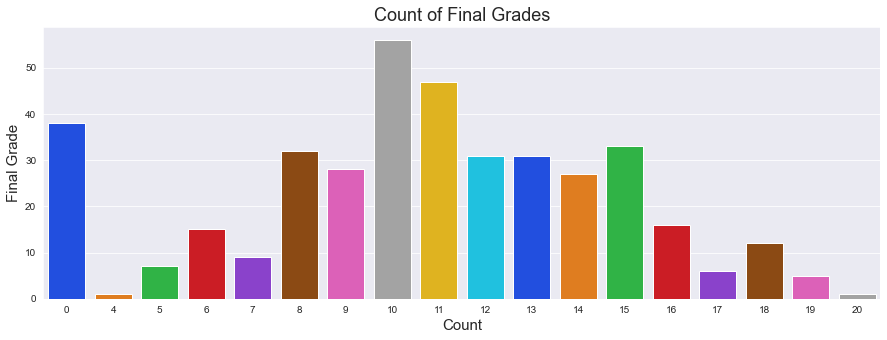

In [7]:
plt.figure(figsize=(15,5))
sns.countplot(x="G3", data=student, palette="bright")
plt.title("Count of Final Grades", fontsize=18)
plt.ylabel("Final Grade", fontsize=15)
plt.xlabel("Count", fontsize=15)

Here we see a skew in the data, giving a abnormal distribution of 0 scores for final grade (G3). We can check to see if there are any null values in G3 that may be causing this:

In [8]:
student["G3"].isnull().any()

False

### Being that this returned with no null values, the unusually high number of 0 scores for the final grade must be due to other reasons. 

This could potentially be: 

 - Absent students
 - Students being excused from taking a final due to having a high grade in a class
 - Take-home exams that were handed in late were defaulted to a 0 grade at the time of the data being updated.

### We should next look into the correlation between G3 and other values in the dataset:

In [9]:
student.corr()["G3"].sort_values()

failures     -0.360415
age          -0.161579
goout        -0.132791
traveltime   -0.117142
health       -0.061335
Dalc         -0.054660
Walc         -0.051939
freetime      0.011307
absences      0.034247
famrel        0.051363
studytime     0.097820
Fedu          0.152457
Medu          0.217147
G1            0.801468
G2            0.904868
G3            1.000000
Name: G3, dtype: float64

### G1 and G2 have very strong correlations. Dropping them would ensure that the models we are going to test do not assign less weight to other values as a result.
(A look into the correlation between G1/G2 and G3 could be an entirely new analysis.)
### We also need to perform encoding, as we have some non-numeric data (Such as Mother's Job/Father's Job).

In [10]:
#dropping of G1 and G2
studentCorr=student.drop(["G1", "G2"], axis="columns")

#encoding of categorical values into dummy/indiactor variables
#documentation for how get_dummies works: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
studentCorr=pd.get_dummies(studentCorr)

#printing the 10 numeric values with the highest correlation to final grade
studentCorr.corr().abs()["G3"].sort_values(ascending=False)[:10]

G3              1.000000
failures        0.360415
Medu            0.217147
higher_yes      0.182465
higher_no       0.182465
age             0.161579
Fedu            0.152457
goout           0.132791
romantic_no     0.129970
romantic_yes    0.129970
Name: G3, dtype: float64

### Highest correlations (grouped together with similar values when applicable):

    1. Number of failures
    2. Mother/Father education
    3. Higher education
    4. Age
    5. Going out
    6. Romantic status 

### Analysis of high-correlation variables

Viewing the head of the encoded table to better give us an idea of how we can visualize these variables.

In [11]:
studentCorr.head(10)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,3,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0
5,16,4,3,1,2,0,5,4,2,1,...,0,1,0,1,0,1,0,1,1,0
6,16,2,2,1,2,0,4,4,4,1,...,1,0,0,1,0,1,0,1,1,0
7,17,4,4,2,2,0,4,1,4,1,...,1,0,0,1,0,1,1,0,1,0
8,15,3,2,1,2,0,4,2,2,1,...,1,0,0,1,0,1,0,1,1,0
9,15,3,4,1,2,0,5,5,1,1,...,0,1,0,1,0,1,0,1,1,0


## Visualizations for the Highest Correlations to Final Grade

### Failures vs. Final Grade

Text(0.5, 0, '# of Failures')

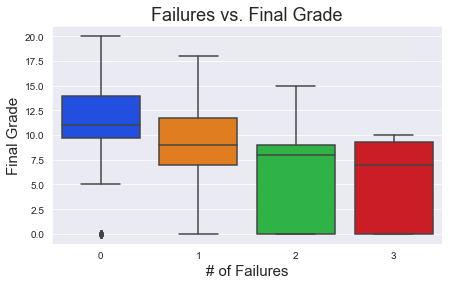

In [12]:
plt.figure(figsize=(7,4))
sns.boxplot(x=student["failures"], y=student["G3"], palette="bright")
plt.title("Failures vs. Final Grade", fontsize=18)
plt.ylabel("Final Grade", fontsize=15)
plt.xlabel("# of Failures", fontsize=15)

We see that those with fewer failures throughout the year have much higher final grades, whereas those with 2 or more failures have the lowest final grades, which is to be expected.

### Parent Education vs. Final Grade

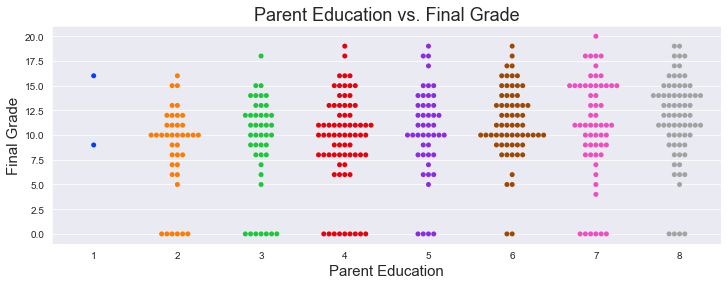

In [13]:
plt.figure(figsize=(12,4))
parent_ed= student["Fedu"] + student["Medu"]
sns.swarmplot(x=parent_ed, y=student["G3"], palette="bright")
plt.title("Parent Education vs. Final Grade", fontsize=18)
plt.ylabel("Final Grade", fontsize=15)
plt.xlabel("Parent Education", fontsize=15)
plt.show()

Here we can see a slight pattern in families with higher levels of education (being closer to 8) resulting in higher grades.
At nearly all levels of Parent Education we see outliers in terms of high/low grades, but the most dense distribution of high grades exists in the 5-8 Parent Education range)

### Intent of Higher Education vs. Final Grade

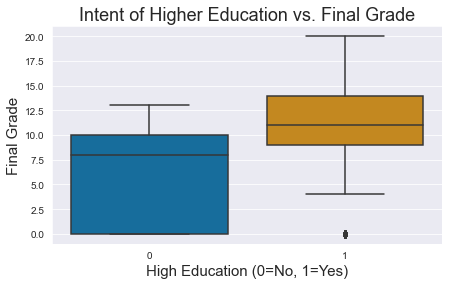

In [14]:
plt.figure(figsize=(7,4))
plot=sns.boxplot(x=studentCorr["higher_yes"], y=student["G3"], palette="colorblind")
plt.title("Intent of Higher Education vs. Final Grade", fontsize=18)
plt.ylabel("Final Grade", fontsize=15)
plt.xlabel("High Education (0=No, 1=Yes)", fontsize=15)
plt.show()

Here we see that those who intend to pursue higher education seem to, overall, achieve higher final grades.

### Age vs. Final Grade

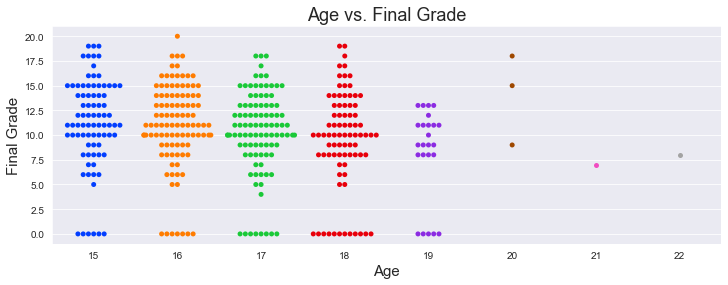

In [15]:
plt.figure(figsize=(12,4))
plot=sns.swarmplot(x=student["age"], y=student["G3"], palette="bright")
plt.title("Age vs. Final Grade", fontsize=18)
plt.ylabel("Final Grade", fontsize=15)
plt.xlabel("Age", fontsize=15)
plt.show()

Aside from a few outliers (primarily those age 20) we see no strong correlation between age and final grade. We can add others factors, like sex, to see if there's any additional information to be found:

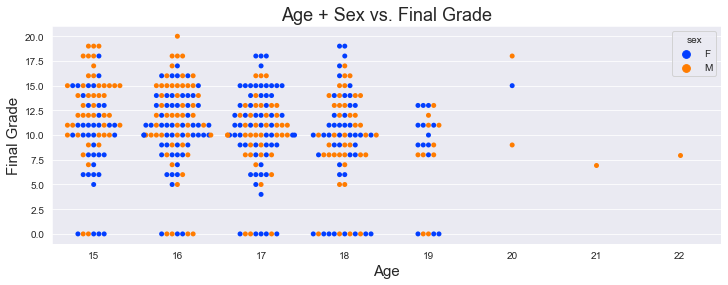

In [16]:
plt.figure(figsize=(12,4))
plot=sns.swarmplot(x=student["age"], y=student["G3"], hue=student["sex"], palette="bright")
plt.title("Age + Sex vs. Final Grade", fontsize=18)
plt.ylabel("Final Grade", fontsize=15)
plt.xlabel("Age", fontsize=15)
plt.show()

Again, here we see no clear indicator of age/sex playing a factor in final grade.

### Frequency of Going Out with Friends vs. Final Grade

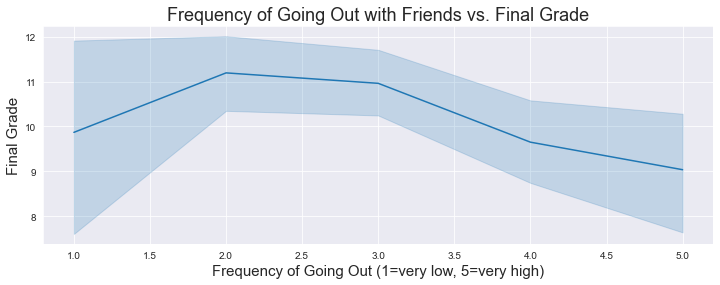

In [17]:
plt.figure(figsize=(12,4))
plot=sns.lineplot(x=student["goout"], y=student["G3"], palette="bright")
plt.title("Frequency of Going Out with Friends vs. Final Grade", fontsize=18)
plt.ylabel("Final Grade", fontsize=15)
plt.xlabel("Frequency of Going Out (1=very low, 5=very high)", fontsize=15)
plt.show()

Here we see that the highest final grades are achieved by those who go out between a moderately low/moderate amount, whereas those who go out at the highest frequency show to have the lowest grades.

### Romantic Status vs. Final Grade

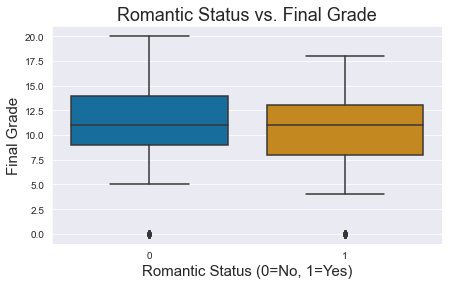

In [18]:
plt.figure(figsize=(7,4))
plot=sns.boxplot(x=studentCorr["romantic_yes"], y=student["G3"], palette="colorblind")
plt.title("Romantic Status vs. Final Grade", fontsize=18)
plt.ylabel("Final Grade", fontsize=15)
plt.xlabel("Romantic Status (0=No, 1=Yes)", fontsize=15)
plt.show()

Here we see that those who are currently in a romantic relationship and those who are not in a romantic relationship achieve *roughly* the same final grade. However, relative to each other, those who are not in a romantic relationship have higher final grades overall.

## Modeling

Here we will compare a selection of different models to see which is the best performing for the prediction of Final Grade (G3).

### Splitting data:

(80% Train 20% Test split)

In [19]:
y=studentCorr["G3"]
x=studentCorr.drop(["G3"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Models to be tested: 

- Linear Regression
- Random Forest Regression
- Epsilon-Support Vector Regression (SVR)
- Gaussian Naive Bayes
- Decision Tree Regressor
- K-Nearest Neighbors
- Multilayer Perceptron (Neural Network)

We can create a function that will go through a list of models that we specify, fit/predict with each model, and provide us withg the mse/rmse into a list.

### Finding Parameters

By utiziling sklearn's GridsearchCV tool, we can automatically determine the highest accuracy parameters for usage in our models, and tune them accordingly.

In [20]:
%%time
#gridsearch for Linear Regression
parameters=[
    {"normalize":["False", "True"]}
]
LR=LinearRegression()
grid_search=GridSearchCV(LR, parameters, cv=5, 
                         scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Wall time: 162 ms


{'normalize': 'False'}

In [21]:
%%time
#gridsearch for Random Forest
parameters=[
    {"max_depth":[2, 4, 6, 12, 20, 40], 
     "n_estimators":[20, 30, 50, 100]}
]
RFG=RandomForestRegressor()
grid_search=GridSearchCV(RFG, parameters, cv=5, 
                         scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Wall time: 13.7 s


{'max_depth': 40, 'n_estimators': 100}

In [22]:
%%time
#gridsearch for Support Vector Regression
parameters=[
    {"gamma":["scale", "auto"],
     "kernel":["linear", "poly", "rbf", "sigmoid"]}
]
SVM=SVR()
grid_search=GridSearchCV(SVM, parameters, cv=5, 
                         scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Wall time: 1.18 s


{'gamma': 'auto', 'kernel': 'rbf'}

In [23]:
%%time
#gridsearch for Gaussian Naive Bayes
parameters=[
    {"var_smoothing":[5, 10, 50, 100, 250, 500, 1000, 10000]}
]
GNB=GaussianNB()
grid_search=GridSearchCV(GNB, parameters, cv=5, 
                         scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Wall time: 439 ms


{'var_smoothing': 100}

In [24]:
%%time
#gridsearch for Decision Tree Regressor
parameters=[
    {"criterion": ["mse", "friedman_mse", "mae"],
     "splitter": ["best", "random"]}
]
DT=DecisionTreeRegressor()
grid_search=GridSearchCV(DT, parameters, cv=5, 
                         scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Wall time: 520 ms


{'criterion': 'mse', 'splitter': 'best'}

In [25]:
%%time
#gridsearch for KNN
parameters=[
    {"n_neighbors":[3, 5, 7, 9, 11, 15, 27],
     "weights":["uniform", "distance"]}
]
KNN=KNeighborsRegressor()
grid_search=GridSearchCV(KNN, parameters, cv=5, 
                         scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Wall time: 1.03 s


{'n_neighbors': 9, 'weights': 'distance'}

In [26]:
%%time
#gridsearch for Multi-layer Perceptron

parameters=[
    {"max_iter":[250, 500, 750],
    "activation":["identity", "logistic", "tanh", "relu"],
     "solver":["lbfgs", "adam"]}
]
MLP=MLPRegressor()
grid_search=GridSearchCV(MLP, parameters, cv=5, 
                         scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Wall time: 1min 25s


{'activation': 'logistic', 'max_iter': 500, 'solver': 'adam'}

### Fitting and Predictions

In [27]:
%%time
def evaluate(x_train, x_test, y_train, y_test):
    model_name_list=["Linear Regression", "Random Forest Regression", "SVM", "Gaussian Naive Bayes", "Decision Tree Regressor", "K-Nearest Neighbors", "Multilayer Perceptron"]
    
    #initiate models with optimal parameters
    LR=LinearRegression(normalize=False)
    RFG=RandomForestRegressor(max_depth=12, n_estimators=100)
    SVM=SVR(gamma="auto", kernel="rbf")
    GNB=GaussianNB(var_smoothing=100)
    DT=DecisionTreeRegressor(criterion="friedman_mse", splitter="best")
    KNN=KNeighborsRegressor(n_neighbors=9, weights="distance")
    MLP=MLPRegressor(activation="tanh", max_iter=250, solver="adam")
 
    #creating df for results
    results=pd.DataFrame(columns=["mse", "rmse"], index=model_name_list)
    
    for i, model in enumerate([LR, RFG, SVM, GNB, DT, KNN, MLP]):
        model.fit(x_train, y_train)
        prediction=model.predict(x_test)
        
        #finding metrics (mean squared error and root mean squared error)
        mse=mean_squared_error(y_test, prediction)
        rmse=sqrt(mse)
        
        #adding model name + results into Results dataframe
        model_name=model_name_list[i]
        results.loc[model_name, :] = [mse, rmse]

    return results

#running evaluate function to get results
results=evaluate(x_train, x_test, y_train, y_test)
results

Wall time: 867 ms


,mse,rmse
Linear Regression,17.6051,4.19584
Random Forest Regression,14.1925,3.7673
SVM,17.1227,4.13796
Gaussian Naive Bayes,21.1013,4.59361
Decision Tree Regressor,21.443,4.63066
K-Nearest Neighbors,16.4809,4.05967
Multilayer Perceptron,16.7251,4.08963


### Determining Best Model

We can then sort the results and return which ones have the lowest MSE and RMSE:

In [28]:
print("Lowest MSE: ",results.sort_values(by=["mse"])[:1])
print("Lowest RMSE:",results.sort_values(by=["rmse"])[:1])

Lowest MSE:                                mse    rmse
Random Forest Regression  14.1925  3.7673
Lowest RMSE:                               mse    rmse
Random Forest Regression  14.1925  3.7673


In this case Random Forest Regression has both the lowest MSE and RMSE, so the conclusion is pretty clear.

Let's create a visualization to easily see how big the discrepancy is between different models' accuracies.

Text(0.5, 0, 'Model')

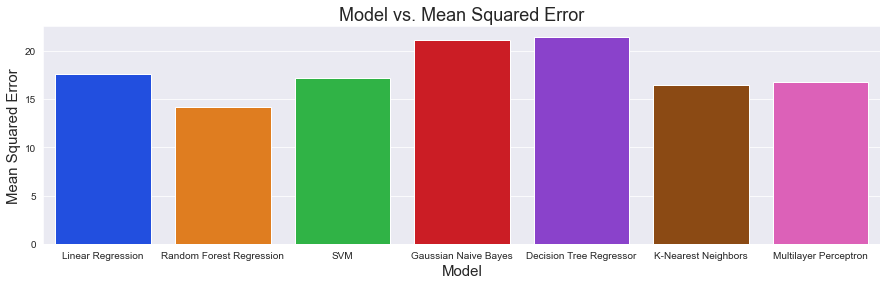

In [29]:
plt.figure(figsize=(15,4))
sns.barplot(x=results.index, y="mse", data=results, palette="bright")
plt.title("Model vs. Mean Squared Error", fontsize=18)
plt.ylabel("Mean Squared Error", fontsize=15)
plt.xlabel("Model", fontsize=15)

Text(0.5, 0, 'Model')

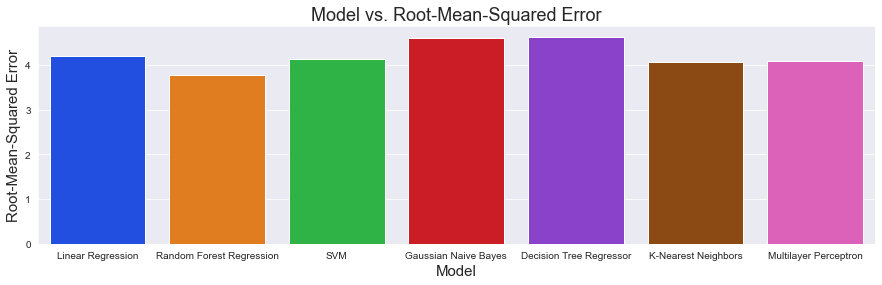

In [30]:
plt.figure(figsize=(15,4))
sns.barplot(x=results.index, y="rmse", data=results, palette="bright")
plt.title("Model vs. Root-Mean-Squared Error", fontsize=18)
plt.ylabel("Root-Mean-Squared Error", fontsize=15)
plt.xlabel("Model", fontsize=15)

## Conclusion

In both the measaurement of MSE and RMSE, Random Forest Regression shows the lowest error, and thus would be the preferable model to use in this situation.